# Week 8 Transit Gaps Group Collaboration Notebook
## Team members: Monisha Reginald, Lucy Briggs, Carolyn Pugh

### Description
<b>Research Question</b>: Where do gaps in access to grocery stores by non-automobile modes exist for seniors who live in the city of Los Angeles?<br>
<b>Notbook Purpose:</b> In this notebook, we will consolidate and provide additional narrative around the work we have developed so far as part of our preparation for our final project.

### Import Libraries

In [1]:
# Import basic packages.
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import fiona 
import numpy as np
import math

# Import packages for plots and maps. 
import folium
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import contextily as ctx
import plotly.express as px

# Import libraries for doing network analysis with open street map. 
import networkx as nx
import osmnx as ox

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


### Part 1: Where do senior residents live within the City of LA? 
In this section, we analyze which areas have higher or lower densities of older residents using census data.  We look at both the block group and neighborhood level.

### Seniors Basemap

In [2]:
#read our pre-made GeoJSON
seniors = gpd.read_file('data/Seniors_Basemap.geojson')
seniors.sample(5)

BG20   ShapeSTArea          FIPS  Total Pop  Age 65-74  Age 75-84  \
930   2395022  2.563607e+06  060372395022       1258         74         10   
795   6004001  1.722869e+06  060376004001       1417        121         13   
2508  1132392  1.056103e+06  060371132392       1438         55         14   
1490  2084012  1.308125e+06  060372084012       2547        174        129   
194   7028022  3.903852e+06  060377028022       1248         97         50   

      Age 85+  Total Senior Pop  Pct Seniors  Square Miles  Pop Density  \
930         9                93     7.392687      0.989810         94.0   
795         0               134     9.456598      0.665200        201.0   
2508       14                83     5.771905      0.407762        204.0   
1490       92               395    15.508441      0.505067        782.0   
194        22               169    13.541667      1.507279        112.0   

       pctcat                                           geometry  
930    0%-10%  POLYGON ((-118.26517 33.97116, -118.26469 33.9...  
795    0%-10%  POLYGON ((-118.31773 33.94547, -118.31725 33.9...  
2508   0%-10%  POLYGON ((-118.60164 34.22819, -118.60304 34.2...  
1490  10%-20%  POLYGON ((-118.27021 34.06188, -118.27078 34.0...  
194   10%-20%  MULTIPOLYGON (((-118.41828 34.00065, -118.4183...

This is our age data basemap made previously in week 4 and 5. I'll include the code for creating the "pctcat" field so we can change the intervals if needed.

In [3]:
seniors.loc[seniors['Pct Seniors'].between(0,20), 'pctcat'] = '0%-20%'
seniors.loc[seniors['Pct Seniors'].between(20,40), 'pctcat'] = '20%-40%'
seniors.loc[seniors['Pct Seniors'] > 40, 'pctcat'] = '40%+'

List all of the different percent categories

In [4]:
pctcats = seniors['pctcat'].unique().tolist()

Create a funciton to make binary maps using a loop. 

In [5]:
def binary():    
    for pct in pctcats:
        fig, ax = plt.subplots(figsize=(5,5))

        # create the map plot
        seniors.plot(ax=ax,
                color='#bababa')

        # create the map plot
        seniors[seniors['pctcat'] == pct].plot(ax=ax,
                # column='pctcat',
                color='#018571')

        # add a title
        ax.set_title('Census Blocks with ' + pct + ' ' + 'Residents Age 65+')
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=4326)

        # get rid of the axis
        ax.axis('off');

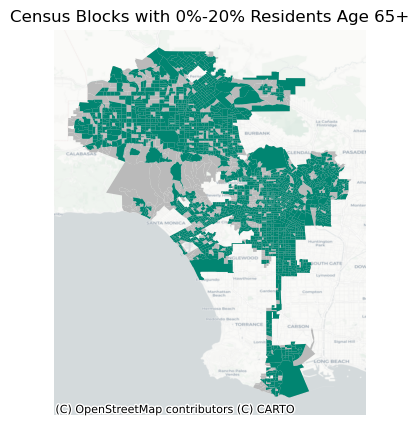

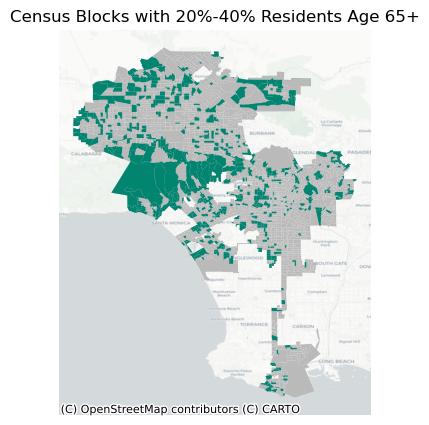

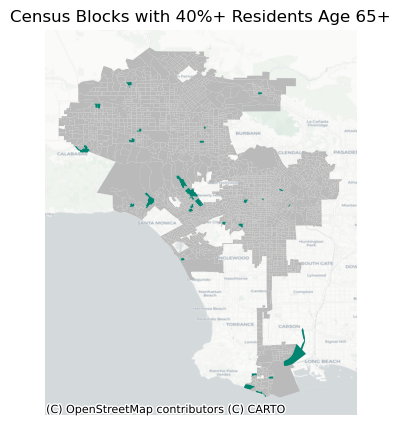

In [6]:
binary()

We can see the few tracts with the highest percentages of seniors. 

### Creating a Seniors Basemap by Neighborhood in addition to the Block Group data

In [7]:
# Import neighborhood boundaries directly from LA GeoHub.
neighborhoods=gpd.read_file(
    'https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson').to_crs('epsg:6423').rename(columns={'name' : 'neighborhood'})
neighborhoods = neighborhoods.to_crs(4326) #converting to the projection of our Seniors data

Steps: 

1. Join the neighborhood boundaries to our seniors data using a spatial join
2. Group by neighborhood and sum the other columns
3. Fix the percentages that were added up
4. Merge the new grouped dataframe with the original neighborhoods data to get the Geometry column back 

In [8]:
#spatial join to neighborhoods
seniors_join = gpd.sjoin(seniors, neighborhoods, how='right')

#group by neighborhood and add up the other columns
neighborhood_seniors = seniors_join.groupby(['neighborhood']).sum(numeric_only=True).reset_index()

#fix the percentage colums
neighborhood_seniors['Pct Seniors']=(neighborhood_seniors['Total Senior Pop']/neighborhood_seniors['Total Pop'])*100

#merge to neighborhoods to get the geometry column back
neighborhood_seniors=pd.merge(neighborhoods,neighborhood_seniors,how="left", 
                              on=['neighborhood']).drop(columns=['OBJECTID_y']).rename(columns={'OBJECTID_x' : 'OBJECTID'})

Now we should have a dataframe that shows our seniors data on the neighborhood level. Create a plot of the highest percentages of senior population. This chart is more useful than our original census block plot, as neighborhoods are more recognizable. 

In [9]:
#Sort to see the top groups
neighborhood_seniors.sort_values('Pct Seniors', inplace=True, ascending=False)

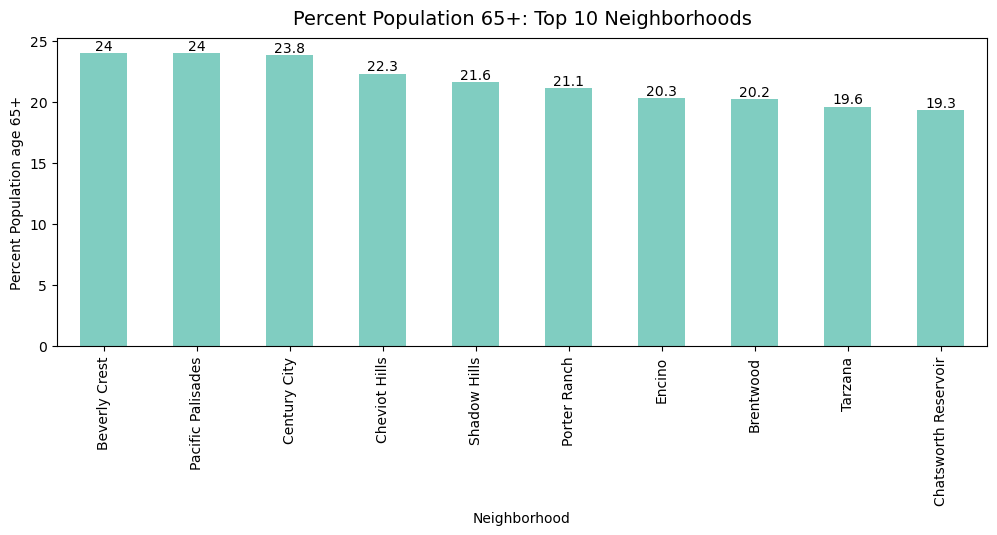

In [10]:
#plot the df
neighborhood_seniors.sort_values('Pct Seniors', inplace=True, ascending=False) #sort to see top 10
neighborhood_seniors['Pct Seniors'] = round(neighborhood_seniors['Pct Seniors'], 1) #round to one decimal place for bar labels
fig, ax = plt.subplots(figsize=(12,4))

neighborhood_seniors[:10].plot.bar(ax=ax,
                                      x='neighborhood',
                                      y='Pct Seniors',
                                      legend=False,
                                      color='#80cdc1'
                                      )
ax.bar_label(ax.containers[0], label_type='edge')
ax.set_xlabel('Neighborhood') # override x label
ax.set_ylabel('Percent Population age 65+') # override y label
ax.set_title("Percent Population 65+: Top 10 Neighborhoods",fontsize=14,pad=10); # multi-line title with padding

Beverly Crest is the neighborhood with the highest percentage of seniors age 65+. 

# Metro Micro

The Metro Micro zones represent areas that already have good access to grocery stores for seniors, as they allow seniors to access transit without walking far to or from their destination or a transit stop. The purpose of our project is to determine where the gaps in transit are across the city, so we must account for Metro Micro zones. In essence, we want to identify potential areas for additional Metro Micro expansion. 
To begin: import our metro micro geojson created in week 4.

In [11]:
micro = gpd.read_file('data/micro.geojson')
micro.sample(5)

name                                           geometry
0        Watts Willowbrook  POLYGON Z ((-118.26535 33.95297 0.00000, -118....
4  North Hollywood/Burbank  POLYGON Z ((-118.34073 34.14307 0.00000, -118....
3               LAX Update  POLYGON Z ((-118.44440 33.96200 0.00000, -118....
1           MOD - El Monte  POLYGON Z ((-118.08420 34.10368 0.00000, -118....
6          UCLA / Westwood  POLYGON Z ((-118.42059 34.05032 0.00000, -118....

# 

Map the metro micro zones with folium

In [12]:
m = folium.Map(location=[34.1,-118.3], 
               zoom_start = 10.45,
               tiles='CartoDB positron', 
               attribution='CartoDB')
#plot polygons
for _, r in micro.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': '#a6611a', "color": "#018571", 'weight': 1.5})
    folium.Popup(r['name']).add_to(geo_j)
    geo_j.add_to(m)
m

In [13]:
m.save('metromicro.html')

### Part 2: Where do Seniors Lack Access to a Vehicle in Los Angeles?

First, we read in the geojson created in the Prep Notebook, which contains information about vehicle ownership for all block groups in the City of Los Angeles.

In [14]:
vehicle_access=gpd.read_file('vehicle_access.geojson')

We are interested in vehicle ownership rates for the City of LA, so we will calcualte stats across the block groups.

In [15]:
# Calculate sum across all block groups (results in a series) and then convert that series to a dataframe.
city_totals=vehicle_access.sum(numeric_only=True).to_frame().transpose()

# Recalculate percentages.
city_totals['Pct Households Without a Vehicle']=(city_totals['Total No Vehicle']/city_totals['Total HH'])*100
city_totals['Pct Senior-Headed Households Without a Vehicle']=(city_totals['Senior No Vehicle']/city_totals['Senior HH'])*100

# Inspect results.
city_totals

Total HH  Senior HH  Total No Vehicle  Senior No Vehicle  \
0  1385427.0   287185.0          161724.0            58193.0   

   Pct Households Without a Vehicle  \
0                         11.673224   

   Pct Senior-Headed Households Without a Vehicle  
0                                       20.263245

We can see that seniors are almost twice as likely to lack access to a household vehicle. We will make a bar chart so that this information can be displayed visually in presentations.

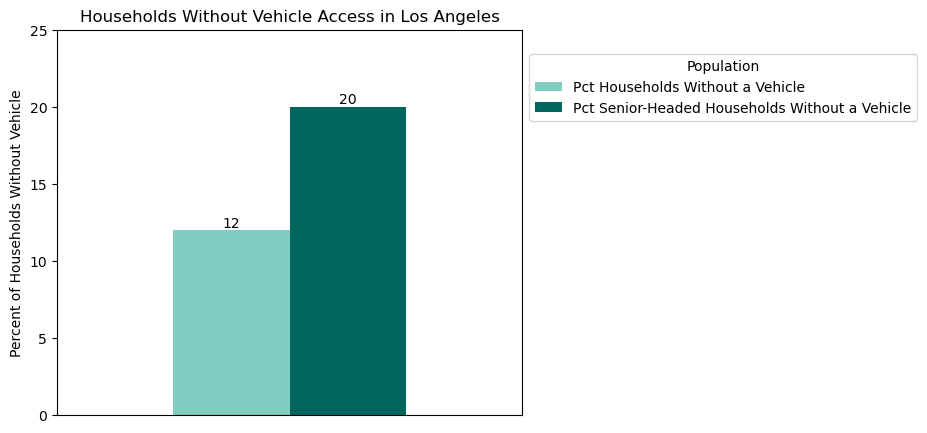

In [16]:
# Create a dataframe for chart with just rounded percentages (so that they can be displayed).
city_bar=city_totals[['Pct Households Without a Vehicle', 'Pct Senior-Headed Households Without a Vehicle']].round()

# Start plot.
fig, ax = plt.subplots(figsize=(6,5))

# Plot data and label the two bars with their values.
ax = city_bar.plot(ax=ax, kind='bar', color=['#80cdc1','#01665e'], legend=True)
ax.bar_label(ax.containers[0], label_type='edge')
ax.bar_label(ax.containers[1], label_type='edge')

# Adjust x-axis so it doesn't have a subtitle or ticks.
plt.xlabel(None)
ax.set_xticks([])

# Ajust y-axis so that it has desired subtitle and ticks.
plt.ylabel("Percent of Households Without Vehicle")
ax.set_yticks((0,5,10,15,20,25))

#Adjust table and legend.
plt.title("Households Without Vehicle Access in Los Angeles")
plt.legend(loc='center left', bbox_to_anchor=(1, .85), title='Population')

plt.show()

We want to understand how vehicle access and senior-vehicle access relate to each other, so we'll create a scatter plot.

Text(0.5, 1.0, 'Household Vehicle Access at Block Group Level')

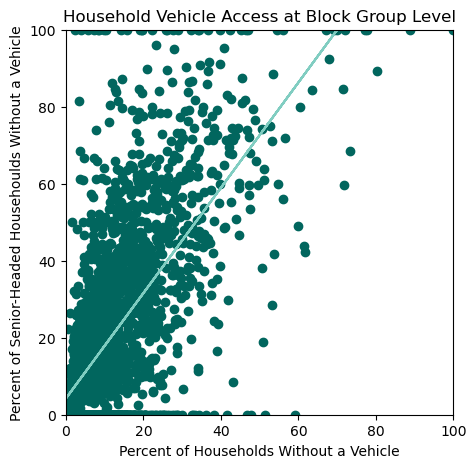

In [17]:
# Create filtered version that exclused all rows with missing data
census_linear=vehicle_access[(vehicle_access["Pct Households Without a Vehicle"]>=0) & (vehicle_access["Pct Senior-Headed Households Without a Vehicle"]>=0)]

# Calculate line of best fit for this filtered dataframe.
m, b = np.polyfit(census_linear["Pct Households Without a Vehicle"], census_linear["Pct Senior-Headed Households Without a Vehicle"], 1)

# Start plot
fig,ax = plt.subplots(figsize=(5,5))

# Plot all points and line of best fit.
ax = plt.plot(census_linear["Pct Households Without a Vehicle"], census_linear["Pct Senior-Headed Households Without a Vehicle"], 'o', color='#01665e')
ax = plt.plot(census_linear["Pct Households Without a Vehicle"], m*census_linear["Pct Households Without a Vehicle"] + b, color='#80cdc1')

plt.xlim(0,100)
plt.xlabel("Percent of Households Without a Vehicle")

plt.ylim(0,100)
plt.ylabel("Percent of Senior-Headed Househoulds Without a Vehicle")

plt.title("Household Vehicle Access at Block Group Level")

From this plot, we can see that vehicle ownership and senior vehicle ownership trend together, but that seniors are systematically less likely to own a vehicle than the general population.

Finally, we want to see this information visually mapped to understand geographic trends. We'll create a new version of this dataframe that replaces "N/A" values (which result when there are either no people or no seniors within a block group) with 0s, so that they are visually grouped with other areas where there is less need to invest in transit infrastructure.

In [18]:
# Create a new dataframe for mapping purposes.
vehicle_map=vehicle_access

# Set value of 0 on rows where the percentages are currently "N/A"
vehicle_map['Pct Households Without a Vehicle'] = vehicle_map['Pct Households Without a Vehicle'].fillna(0)
vehicle_map['Pct Senior-Headed Households Without a Vehicle'] = vehicle_map['Pct Senior-Headed Households Without a Vehicle'].fillna(0)

We want to map the block groups pased on their senior vehicle-ownership percentages, so we'll categorize them based on areas with no vehicle-free househoulds, areas where 0-20% of senior-headed households lack a vehicle, and areas where over 20% (the City average) of senior-headed households lack a vehicle. Note that these percentages can be adjusted.

In [19]:
# First we have to sort and re-index this dataframe so the row number corresponds to its rank.
vehicle_map=vehicle_map.sort_values(by=['Pct Senior-Headed Households Without a Vehicle']).reset_index().drop(columns=['index'])

# Categorize rows according to their row percentile
vehicle_map['Senior_Category']= '0% of Senior-Headed Households Lack Vehicle'
vehicle_map.loc[vehicle_map['Pct Senior-Headed Households Without a Vehicle'] > 0, 'Senior_Category'] = "1-20% of Senior-Headed Households Lack Vehicle"
vehicle_map.loc[vehicle_map['Pct Senior-Headed Households Without a Vehicle'] > 20, 'Senior_Category'] = "Over 20% of Senior-Headed Households Lack Vehicle"

Now we can make the map!

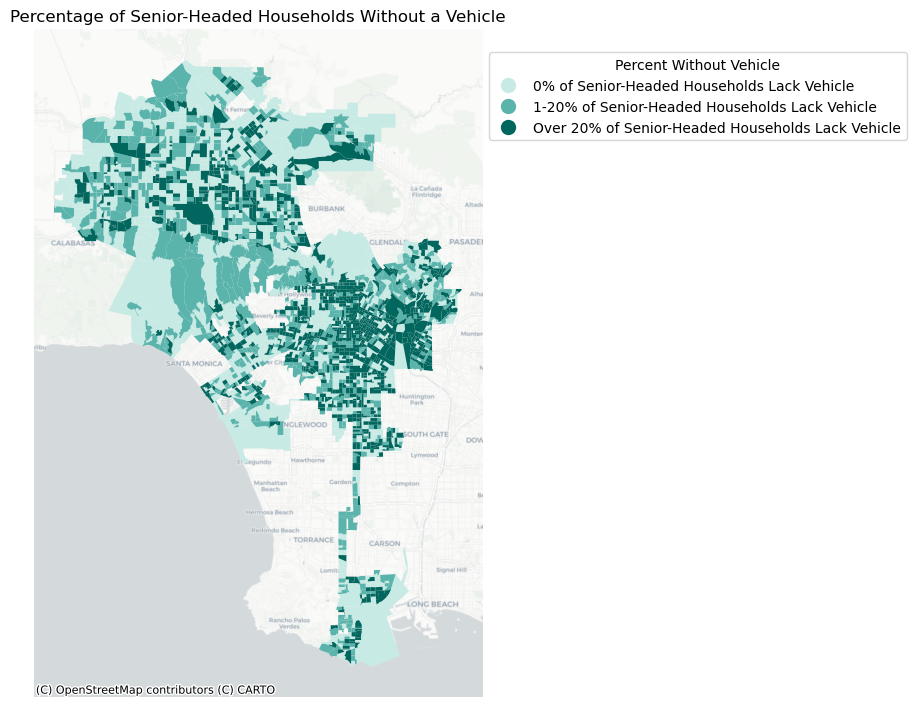

In [20]:
# Since Python doesn't want me to specific a color and a colomn within the same plot, I'll first create a color column and then a manual legend.
color_dict = {'0% of Senior-Headed Households Lack Vehicle' : '#c7eae5',
              '1-20% of Senior-Headed Households Lack Vehicle': '#5ab4ac',
              'Over 20% of Senior-Headed Households Lack Vehicle': '#01665e'}

vehicle_map["colors"] = vehicle_map["Senior_Category"].map(color_dict)

# Now I create my actual map with the three geodataframes added in the appropriate order (zorder).
fig,ax = plt.subplots(figsize=(8,8))
ax = vehicle_map.plot(ax=ax, color=vehicle_map["colors"])

# Add manual legend.
from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
ax.legend(custom_points, color_dict.keys(), loc="center left", bbox_to_anchor=(1,.9), title="Percent Without Vehicle")


#Format plot.
ax.axis('off')
ax.set_title('Percentage of Senior-Headed Households Without a Vehicle')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

plt.tight_layout()

This map is helful for understanding the detailed geographic trends - the areas with the lowest car ownership seem to be concentrated near Centeral Los Angeles and also scattered throughout the San Fernando Valley. However, to aid our selection of neighborhoods, we also want to understand vehicle access by neighborhood. To do this, we will aggregate data by neighborhood and then recalculate car ownership rates.

In [21]:
# Import neighborhood boundaries directly from LA GeoHub.
neighborhoods=gpd.read_file(
    'https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson').to_crs('epsg:6423').rename(columns={'name' : 'neighborhood'})

In [22]:
# Create a new dataframe with totals for each neighborhood that sums up all relevant columns.
vehicles_by_neighborhood = vehicle_access.groupby(['neighborhood']).sum(numeric_only=True).reset_index()

# Recalculate percentages.
vehicles_by_neighborhood['Pct Households Without a Vehicle']=(vehicles_by_neighborhood['Total No Vehicle']/vehicles_by_neighborhood['Total HH'])*100
vehicles_by_neighborhood['Pct Senior-Headed Households Without a Vehicle']=(vehicles_by_neighborhood['Senior No Vehicle']/vehicles_by_neighborhood['Senior HH'])*100

# Finally, we have to add back in the geometry column from the original neighborhood geodataframe.
vehicles_by_neighborhood=pd.merge(neighborhoods[['neighborhood','geometry']],vehicles_by_neighborhood,how="left", on=['neighborhood'])

# See how this table looks.
vehicles_by_neighborhood.head()

neighborhood                                           geometry  \
0         Adams-Normandie  POLYGON ((1972233.388 559643.685, 1971938.035 ...   
1                  Arleta  POLYGON ((1959244.309 584850.051, 1959257.540 ...   
2       Arlington Heights  POLYGON ((1970582.552 561395.372, 1970757.410 ...   
3         Atwater Village  MULTIPOLYGON (((1974284.934 572493.221, 197428...   
4  Baldwin Hills/Crenshaw  POLYGON ((1966656.952 558331.179, 1966727.113 ...   

   Total HH  Senior HH  Total No Vehicle  Senior No Vehicle  \
0      5141        915               960                294   
1      7950       1791               337                164   
2      6220       1151               940                256   
3      4782       1207               279                126   
4     14391       3609              2323                835   

   Pct Households Without a Vehicle  \
0                         18.673410   
1                          4.238994   
2                         15.112540   
3                          5.834379   
4                         16.142033   

   Pct Senior-Headed Households Without a Vehicle  
0                                       32.131148  
1                                        9.156896  
2                                       22.241529  
3                                       10.439105  
4                                       23.136603

First, I will create a scatter plot to get a general picture of vehicle access and senior vehicle access at the neighborhoood level.

Text(0.5, 1.0, 'Household Vehicle Access at Neighborhood Level')

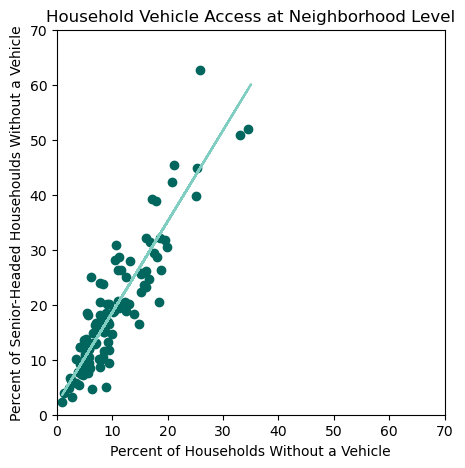

In [23]:
neighborhood_linear=vehicles_by_neighborhood[(vehicles_by_neighborhood["Pct Households Without a Vehicle"]>=0) &
                                      (vehicles_by_neighborhood["Pct Senior-Headed Households Without a Vehicle"]>=0)]

# Create line of best fit.
m, b = np.polyfit(neighborhood_linear["Pct Households Without a Vehicle"], neighborhood_linear["Pct Senior-Headed Households Without a Vehicle"], 1)

fig,ax = plt.subplots(figsize=(5,5))

# Plot scatter plot and line of best fit.
ax = plt.plot(neighborhood_linear["Pct Households Without a Vehicle"], neighborhood_linear["Pct Senior-Headed Households Without a Vehicle"],
              'o', color='#01665e')
ax = plt.plot(neighborhood_linear["Pct Households Without a Vehicle"], m*neighborhood_linear["Pct Households Without a Vehicle"] + b,
             color='#80cdc1')

plt.xlim(0,70)
plt.xlabel("Percent of Households Without a Vehicle")

plt.ylim(0,70)
plt.ylabel("Percent of Senior-Headed Househoulds Without a Vehicle")

plt.title("Household Vehicle Access at Neighborhood Level")

This scatter plot shows that vehicle access and senior vehicle access trend closely, but that seniors are much less likely to own a vehicle. This scatter plot also helps us understand that there are 10 neighborhoods that have particularly high rates of zero-vehicle households (the 10 points far away from the cluster of other points). To understand where these outliers are, we created a bar chart of the top 10 neighborhoods where senior-headed households are the least likely to own a vehicle.

Text(0.5, 1.0, 'Top 10 Neighborhoods by Pct of Senior-Headed Households That Do Not Have Vehicle')

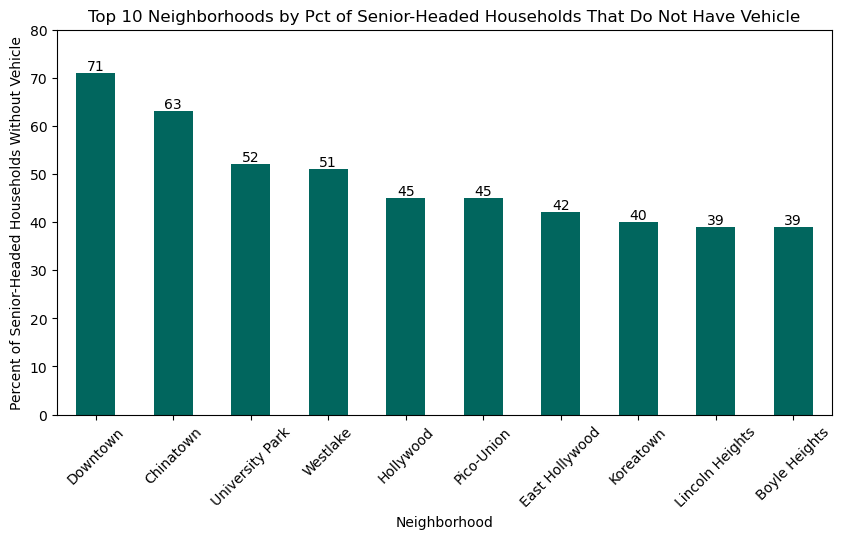

In [24]:
# Create a dataframe for chart with sorted, rounded percentages (so that they can be displayed).
neighborhood_bar=vehicles_by_neighborhood[['neighborhood','Pct Senior-Headed Households Without a Vehicle']].round().sort_values(by=['Pct Senior-Headed Households Without a Vehicle'],ascending=False)

# Start plot.
fig, ax = plt.subplots(figsize=(10,5))
ax = neighborhood_bar[:10].plot(ax=ax, kind='bar', x='neighborhood', y= 'Pct Senior-Headed Households Without a Vehicle', color=['#01665e'], legend=False)
ax.bar_label(ax.containers[0], label_type='edge')

# Adjust x-axis.
plt.xlabel("Neighborhood")
plt.xticks(rotation=45)

# Ajust y-axis.
plt.ylabel("Percent of Senior-Headed Households Without Vehicle")
ax.set_yticks((0,10,20,30,40,50,60,70,80))

#Adjust table and legend.
plt.title("Top 10 Neighborhoods by Pct of Senior-Headed Households That Do Not Have Vehicle")

From this chart, we learn that the neighborhoods where seniors are concentrated in Central and East Los Angeles.

### Part 3: What does grocery store access look like in Los Angeles?

Next, we turn to the question of where chain grocery stores are located within the City of Los Angeles. Although we would prefer to include non-chain grocery stores as well, there's no reasonable way to identify them for the entire City of Los Angeles. We will likely be able to manually include these if we zoom in on a small number of neighborhoods in future analysis. <br>First, we read in the geojson created in the Prep Notebook, which contains information about the grocery stores. For initial analysis, we want to analyze just grocery chains within the municipal border.

In [25]:
# Read file.
grocery_chains=gpd.read_file('chain_with_neighborhood.geojson')

# Create new geodataframe with just chains within the City of LA.
chain_with_neighborhood=grocery_chains[grocery_chains['neighborhood'].notna()].copy().reset_index().drop(columns=['index'])

We want to make a map of grocery stores in Los Angeles categorized by their chain. However, there are too many supermarket chains to map them with every chain as its own category, so I will create a new dataframe for the primary purpose of mapping. This new dataframe will contain a column (chain_map) that contains the chain's name for very big chains, and the chain type for smaller chains. First, I determine what the top 5 chains are.

In [26]:
# Display fist five items in a new dataframe with counts of each chain.
top_chains = chain_with_neighborhood.value_counts(['chain_name']).reset_index(name='count').iloc[:5]
top_chains

chain_name  count
0         Ralphs     43
1         Target     30
2  Smart & Final     30
3   Trader Joe's     22
4    Food 4 Less     21

Now I can use this information to create my new chain_map categories.

In [27]:
#Create new geodataframe for map.
chain_map=chain_with_neighborhood.copy()

# Create new variable that defaults to the chain type.
chain_map['chain_map'] = chain_map['chain_type']

# Replace value with the chain's name for Top 5 Chains.
chain_map.loc[chain_map['chain_name'] == "Ralphs", 'chain_map'] = "Ralphs"
chain_map.loc[chain_map['chain_name'] == "Smart & Final", 'chain_map'] = "Smart & Final"
chain_map.loc[chain_map['chain_name'] == "Target", 'chain_map'] = "Target"
chain_map.loc[chain_map['chain_name'] == "Trader Joe's", 'chain_map'] = "Trader Joe's"
chain_map.loc[chain_map['chain_name'] == "Food 4 Less", 'chain_map'] = "Food 4 Less"

# See how many stores there are in each mapping category.
chainmap_counts = chain_map.value_counts(['chain_map']).reset_index(name='count')
chainmap_counts

chain_map  count
0  Standard chain (e.g. Ralphs, Trader Joe's)    102
1                                      Ralphs     43
2         Upscale (e.g. Whole Foods, Sprouts)     38
3                               Smart & Final     30
4                                      Target     30
5  Discount (e.g. Smart & Final, Food 4 Less)     25
6                                Trader Joe's     22
7                                 Food 4 Less     21
8     Department store (e.g. Target, Walmart)      5

I notice that by pulling the Targets out separately, there aren't enough department stores to map as a category, so I'll fold these into standard chains.

In [28]:
chain_map.loc[chain_map['chain_name'] == "Walmart", 'chain_map'] = "Standard chain (e.g. Ralphs, Trader Joe's)"

Finally, I must rename my categories to remove references to chains that have been pulled out.

In [29]:
chain_map.loc[chain_map['chain_map'] == "Standard chain (e.g. Ralphs, Trader Joe's)", 'chain_map'] = "Other Standard Chain (e.g. Vons)"
chain_map.loc[chain_map['chain_map'] == "Discount (e.g. Smart & Final, Food 4 Less)", 'chain_map'] = "Other Discount Chain (e.g. Mother's Nutritional Center)"
chain_map.loc[chain_map['chain_map'] == "Upscale (e.g. Whole Foods, Sprouts)", 'chain_map'] = "Upscale Chain (e.g. Whole Foods)"

# See how many stores there are in each mapping category.
chainmap_counts = chain_map.value_counts(['chain_map']).reset_index(name='count')
chainmap_counts

chain_map  count
0                   Other Standard Chain (e.g. Vons)    107
1                                             Ralphs     43
2                   Upscale Chain (e.g. Whole Foods)     38
3                                      Smart & Final     30
4                                             Target     30
5  Other Discount Chain (e.g. Mother's Nutritiona...     25
6                                       Trader Joe's     22
7                                        Food 4 Less     21

Now I can create an interactive map that has the locations of each supermarket chain grocery store in the City of LA. This map helps us understand the spatial distribution of chains overall and _which_ chains are in which areas.

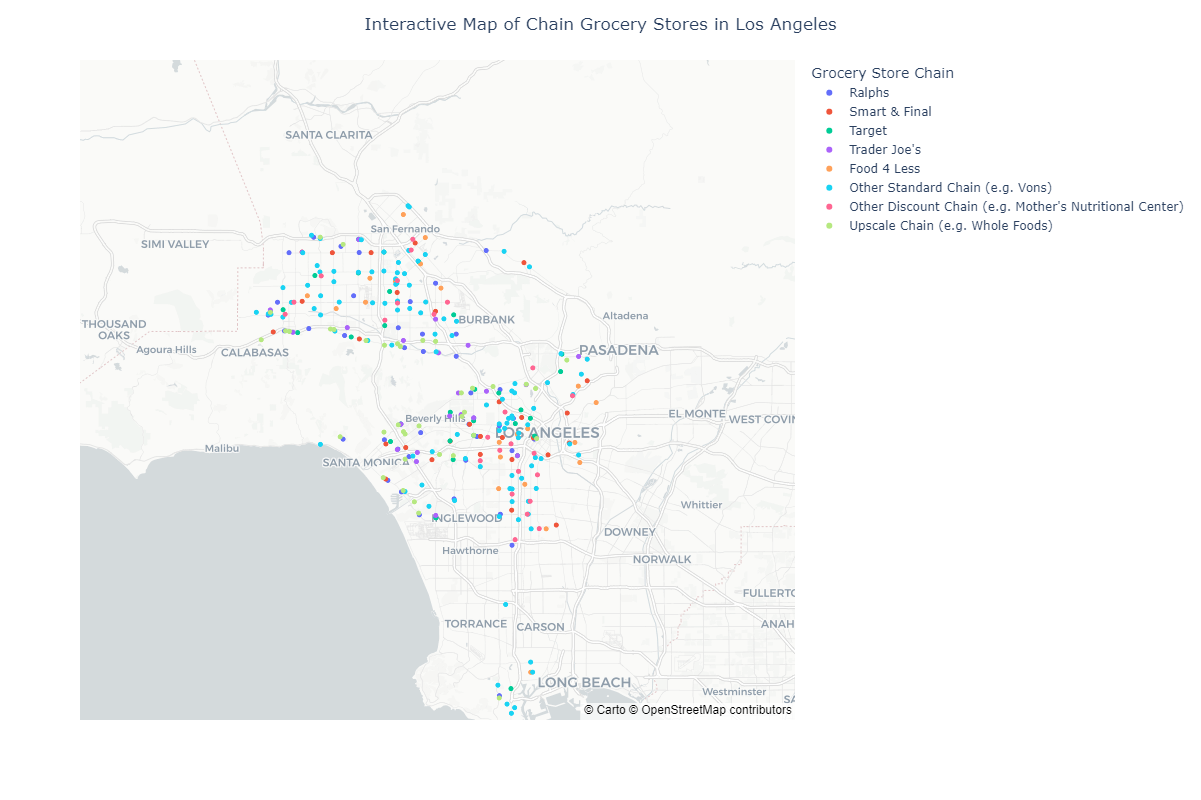

In [30]:
# Create an order column with the desired order (in the legend I want first the top 5 chains in descending order of prevalence and then the chain groups)
chain_map.loc[chain_map['chain_map'] == "Ralphs", 'chain_map_order'] = 1
chain_map.loc[chain_map['chain_map'] == "Smart & Final", 'chain_map_order'] = 2
chain_map.loc[chain_map['chain_map'] == "Target", 'chain_map_order'] = 3
chain_map.loc[chain_map['chain_map'] == "Trader Joe's", 'chain_map_order'] = 4
chain_map.loc[chain_map['chain_map'] == "Food 4 Less", 'chain_map_order'] = 5
chain_map.loc[chain_map['chain_map'] == "Other Standard Chain (e.g. Vons)", 'chain_map_order'] = 6
chain_map.loc[chain_map['chain_map'] == "Other Discount Chain (e.g. Mother's Nutritional Center)", 'chain_map_order'] = 7
chain_map.loc[chain_map['chain_map'] == "Upscale Chain (e.g. Whole Foods)", 'chain_map_order'] = 8

# Sort by my new order column.
chain_map=chain_map.sort_values('chain_map_order')

# Create an interactive map where markers are colored by the name of the chain.
fig = px.scatter_mapbox(chain_map,
                        lat='Latitude',
                        lon='Longitude',
                        color='chain_map',
                        mapbox_style="carto-positron",
                        labels={
                            'chain_map':'Grocery Store Chain',
                        })

# Update layout with desired size, zoom, title, etc.
# Chart specifically must be wider to accomodate the longer names in the legend.
fig.update_layout(
    width = 950,
    height = 800,
    mapbox_style="carto-positron",
    mapbox_zoom=9,
    title = "Interactive Map of Chain Grocery Stores in Los Angeles",
    title_x=0.5)

fig.show()

Exploring this map helps us understand geographic trends - for example, Ralphs has virtually no presence east of Downtown despite being the largest chain in the region. Additionally, you can see very start indications of segregation. While "Discount Chains" are concentrated in South LA, "Upscale Chains" are generally concentrated in West LA and along the 101. These trends are interesting for thinking about grocery store access in terms of affordability in addition to physical accessibility.

Now we turn our attention to the question of which areas are within walking distance of a grocery store. First, we'll read in the geojsons that we'll need, with the most notable one being the dataframe of walksheds created in the Prep Notebook.

In [31]:
# Read the geojson from the prep notebook that has walkshed geometries.
walksheds=gpd.read_file('grocery_walksheds.geojson')

# Read the geojson from the prep notebook that has census block group geometries.
bg_geometries=gpd.read_file('bg_geometries.geojson')

# Import LA City boundary directly from Los Angeles GeoHub. 
cityboundary_proj=gpd.read_file("https://maps.lacity.org/lahub/rest/services/Boundaries/MapServer/7/query?outFields=*&where=1%3D1&f=geojson").to_crs('epsg:6423')

# Import neighborhood boundaries directly from LA GeoHub.
neighborhoods=gpd.read_file(
    'https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson').to_crs('epsg:6423').rename(columns={'name' : 'neighborhood'})

# Read the geojson from the prep notebook that has population access.
senior_grocery=gpd.read_file('senior_grocery.geojson')

First, we'll create a map to visualize these walksheds.

/opt/conda/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



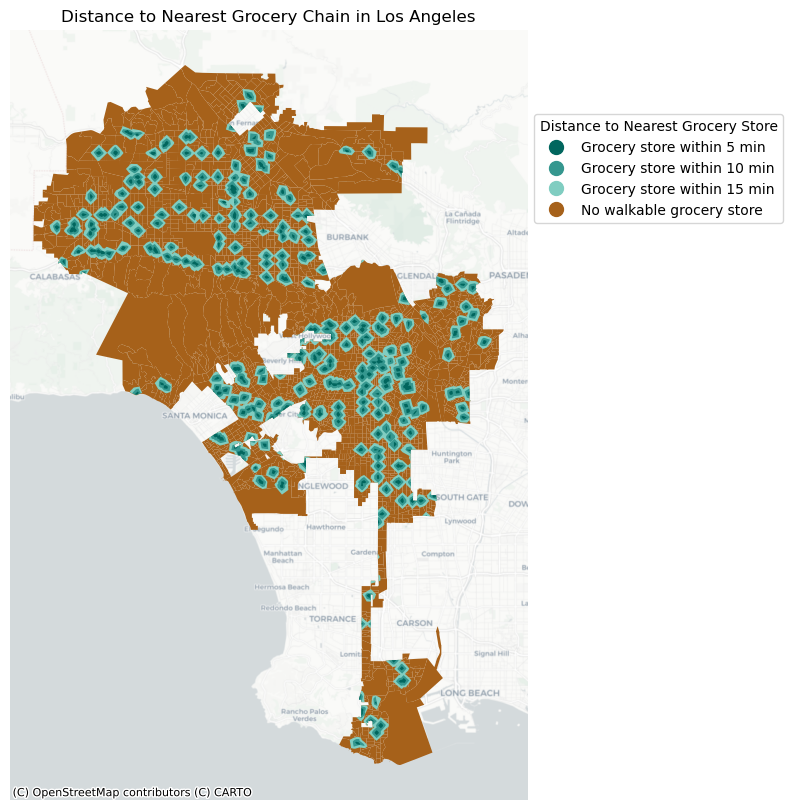

In [32]:
# Walksheds can expand into other municipalities, so we will clip the walkshed to the LA boundary.
walksheds_map=gpd.clip(walksheds, cityboundary_proj).sort_values(by=['time'],ascending=False)
bg_geometries['colors']='#a6611a'

# Now I create my actual map with the three geodataframes added in the appropriate order (zorder).
fig,ax = plt.subplots(figsize=(10,10))

#chain_with_neighborhood.plot(ax=ax, zorder=3,color='orange')
bg_geometries.plot(ax=ax, color=bg_geometries['colors'])
walksheds_map.plot(ax=ax, color=walksheds_map['colors'])

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [(Line2D([0], [0], marker='o', color='#01665e', linestyle='',label='Grocery store within 5 min', markersize=10)),
                   (Line2D([0], [0], marker='o', color='#35978f', linestyle='',label='Grocery store within 10 min', markersize=10)),
                   (Line2D([0], [0], marker='o', color='#80cdc1', linestyle='',label='Grocery store within 15 min', markersize=10)),
                   (Line2D([0], [0], marker='o', color='#a6611a', linestyle='',label='No walkable grocery store', markersize=10))]
ax.legend(handles=legend_elements,loc='upper left', bbox_to_anchor=(1,.9), title="Distance to Nearest Grocery Store")


#Format plot axis, title, and basemap.
ax.axis('off')
ax.set_title('Distance to Nearest Grocery Chain in Los Angeles')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

We can also map the census blocks categorized by their walk access to grocery stores.

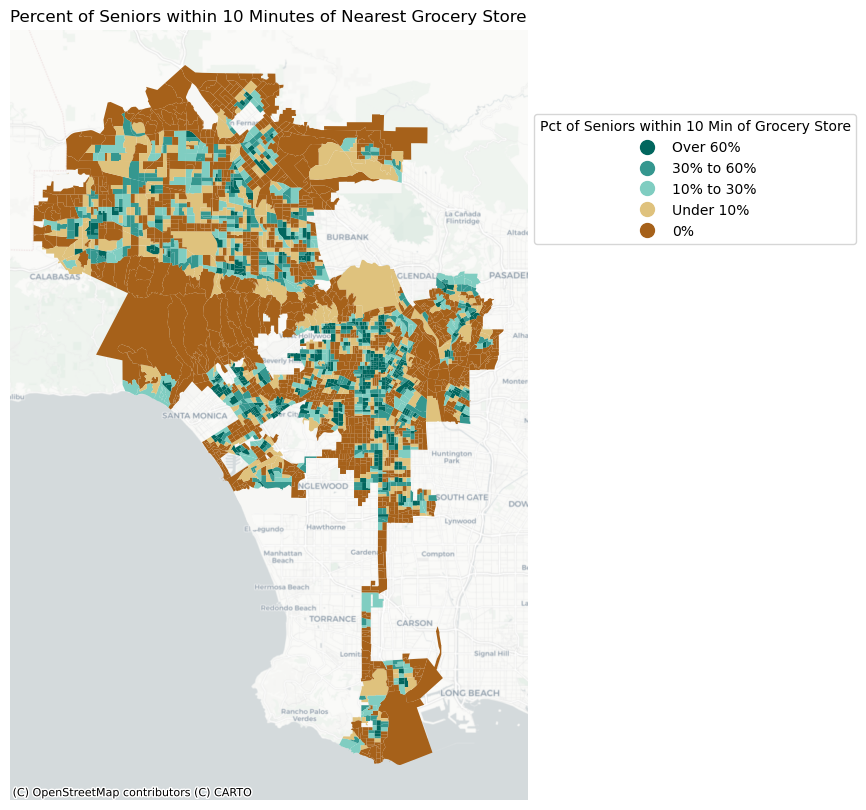

In [33]:
# Plot data.
fig, ax = plt.subplots(figsize=(10, 10))
senior_grocery.plot(ax=ax,color=senior_grocery['colors'])

# Build custom legend
legend_elements = [(Line2D([0], [0], marker='o', color='#01665e', linestyle='',label='Over 60%', markersize=10)),
                  (Line2D([0], [0], marker='o', color='#35978f', linestyle='',label='30% to 60%', markersize=10)),
                  (Line2D([0], [0], marker='o', color='#80cdc1', linestyle='',label='10% to 30%', markersize=10)),
                  (Line2D([0], [0], marker='o', color='#dfc27d', linestyle='',label='Under 10%', markersize=10)),
                  (Line2D([0], [0], marker='o', color='#a6611a', linestyle='',label='0%', markersize=10))]
ax.legend(handles=legend_elements,loc='upper left', bbox_to_anchor=(1,.9), title="Pct of Seniors within 10 Min of Grocery Store")

# Format axis, title, and basemap.
ax.axis("off")
ax.set_title("Percent of Seniors within 10 Minutes of Nearest Grocery Store")
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

plt.show()

We can also use this information to do some basic calculations about how likely Seniors are to live within walking distance of a grocery chain, and whether they have worse (or better) acess than the general population of Los Angeles.

First, I want to create a new table that sums up all of the data across all block groups, so that I can conduct calculations about what percentage of Seniors and All Residents live within walking distance of a grocery store for the City of Los Angeles as a whole.

In [34]:
# Sum up all of the data for all of the block groups in each category.
senior_sums = senior_grocery.sum(numeric_only=True)
senior_sums=pd.DataFrame(senior_sums).transpose()
senior_sums['pct_5_min']=round(100*senior_sums['all_5_min']/senior_sums['Total_Pop'])
senior_sums['pct_10_min']=round(100*senior_sums['all_10_min']/senior_sums['Total_Pop'])
senior_sums['pct_15_min']=round(100*senior_sums['all_15_min']/senior_sums['Total_Pop'])
senior_sums['pct_none']=round(100*senior_sums['all_none']/senior_sums['Total_Pop'])
senior_sums['seniors_pct_5_min']=round(100*senior_sums['seniors_5_min']/senior_sums['Total Senior Pop'])
senior_sums['seniors_pct_10_min']=round(100*senior_sums['seniors_10_min']/senior_sums['Total Senior Pop'])
senior_sums['seniors_pct_15_min']=round(100*senior_sums['seniors_15_min']/senior_sums['Total Senior Pop'])
senior_sums['seniors_none']=round(100*senior_sums['seniors_none']/senior_sums['Total Senior Pop'])


senior_sums_all=senior_sums[['pct_5_min','pct_10_min','pct_15_min','pct_none']]
senior_sums_all['population']='All Residents'
senior_sums_seniors=senior_sums[['seniors_pct_5_min','seniors_pct_10_min','seniors_pct_15_min','seniors_none']].rename(columns={
    'seniors_pct_5_min':'pct_5_min', 'seniors_pct_10_min':'pct_10_min', 'seniors_pct_15_min':'pct_15_min', 'seniors_none':'pct_none'})
senior_sums_seniors['population']='Seniors'
grocery_table=pd.concat([senior_sums_all,senior_sums_seniors])
grocery_table=grocery_table.reset_index().drop(columns=['index','pct_15_min'])

# Take a look at our table.
grocery_table

/tmp/ipykernel_156/1330527046.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



pct_5_min  pct_10_min  pct_none     population
0        4.0        20.0      80.0  All Residents
1        4.0        18.0      82.0        Seniors

Now we can create our bar plot.

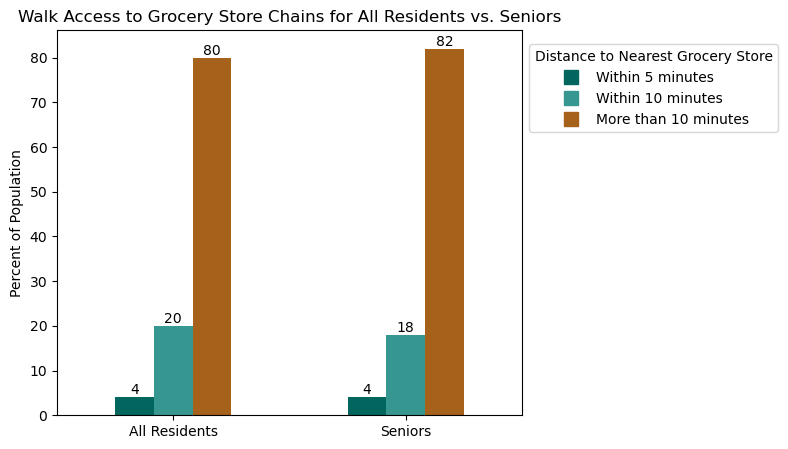

In [35]:
# Now I plot the pivot table.
fig, ax = plt.subplots(figsize=(6,5))

ax = grocery_table.plot(ax=ax, kind='bar',x='population', color=['#01665e','#35978f','#a6611a'] , legend=True)
ax.bar_label(ax.containers[0], label_type='edge')
ax.bar_label(ax.containers[1], label_type='edge')
ax.bar_label(ax.containers[2], label_type='edge')

# Adjust x-axis.
plt.xlabel(None)
plt.xticks(rotation=0)

# Ajust y-axis.
plt.ylabel("Percent of Population")

#Adjust table and legend.
plt.title("Walk Access to Grocery Store Chains for All Residents vs. Seniors")

# build custom legend
legend_elements = [(Line2D([0], [0], marker='s', color='#01665e', linestyle='',label='Within 5 minutes', markersize=10)),
                  (Line2D([0], [0], marker='s', color='#35978f', linestyle='',label='Within 10 minutes', markersize=10)),
                  (Line2D([0], [0], marker='s', color='#a6611a', linestyle='',label='More than 10 minutes', markersize=10))]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, .85), title='Distance to Nearest Grocery Store')

plt.show()

We can see from this chart that Seniors are more likely to live in a census block group that does not have a walkable grocery store (82% compared to 80%).

The final step is to understand which neighborhoods have particularly low access for seniors. We summarize this data by neighborhood.

In [36]:
# Create a new dataframe with totals for each neighborhood that sums up all relevant columns.
grocery_by_neighborhood = senior_grocery.groupby(['neighborhood']).sum(numeric_only=True).reset_index()

# Recalculate percentages.
grocery_by_neighborhood['pct_snr_5_min']=(grocery_by_neighborhood['seniors_5_min']/grocery_by_neighborhood['Total Senior Pop'])
grocery_by_neighborhood['pct_snr_10_min']=(grocery_by_neighborhood['seniors_10_min']/grocery_by_neighborhood['Total Senior Pop'])
grocery_by_neighborhood['pct_snr_15_min']=(grocery_by_neighborhood['seniors_15_min']/grocery_by_neighborhood['Total Senior Pop'])
grocery_by_neighborhood['pct_snr_none']=(grocery_by_neighborhood['seniors_none']/grocery_by_neighborhood['Total Senior Pop'])

# Finally, we have to add back in the geometry column from the original neighborhood geodataframe.
grocery_by_neighborhood=pd.merge(neighborhoods[['neighborhood','geometry']],grocery_by_neighborhood,how="left", on=['neighborhood'])

# Keep just necessary columns.
grocery_by_neighborhood=grocery_by_neighborhood[['neighborhood','geometry','pct_snr_5_min','pct_snr_10_min','pct_snr_15_min','pct_snr_none']]

# Add in neighborhood colors for mapping.
for index, row in grocery_by_neighborhood.iterrows():
    if grocery_by_neighborhood.loc[index, 'pct_snr_10_min'] ==0:
        grocery_by_neighborhood.loc[index, 'colors'] = '#a6611a'
    elif grocery_by_neighborhood.loc[index, 'pct_snr_10_min'] < .1:
        grocery_by_neighborhood.loc[index, 'colors'] = '#dfc27d'
    elif grocery_by_neighborhood.loc[index, 'pct_snr_10_min'] < .3:
        grocery_by_neighborhood.loc[index, 'colors'] = '#80cdc1'
    elif grocery_by_neighborhood.loc[index, 'pct_snr_10_min'] < .6:
        grocery_by_neighborhood.loc[index, 'colors'] = '#35978f'
    elif grocery_by_neighborhood.loc[index, 'pct_snr_10_min'] <= 1:
        grocery_by_neighborhood.loc[index, 'colors'] = '#01665e'
    else:
        grocery_by_neighborhood.loc[index, 'colors'] = '#f7f7f5'

# See how this table looks.
grocery_by_neighborhood.sort_values('pct_snr_none',ascending=True).head(5)

neighborhood                                           geometry  \
52         Koreatown  POLYGON ((1973426.406 562358.370, 1973427.701 ...   
49         Hollywood  POLYGON ((1969734.109 567209.707, 1969839.499 ...   
43   Harvard Heights  POLYGON ((1972240.553 560032.451, 1972223.927 ...   
106         Westlake  POLYGON ((1976080.190 561472.084, 1976010.254 ...   
80          Sawtelle  POLYGON ((1959009.539 560789.257, 1959806.166 ...   

     pct_snr_5_min  pct_snr_10_min  pct_snr_15_min  pct_snr_none   colors  
52        0.147267        0.544597        0.795689      0.455403  #35978f  
49        0.097670        0.457952        0.773800      0.542048  #35978f  
43        0.089863        0.456966        0.878488      0.543034  #35978f  
106       0.083579        0.440776        0.897137      0.559224  #35978f  
80        0.104077        0.399226        0.716128      0.600774  #35978f

Now we can visualize how access varies by block group _and_ neighborhood.

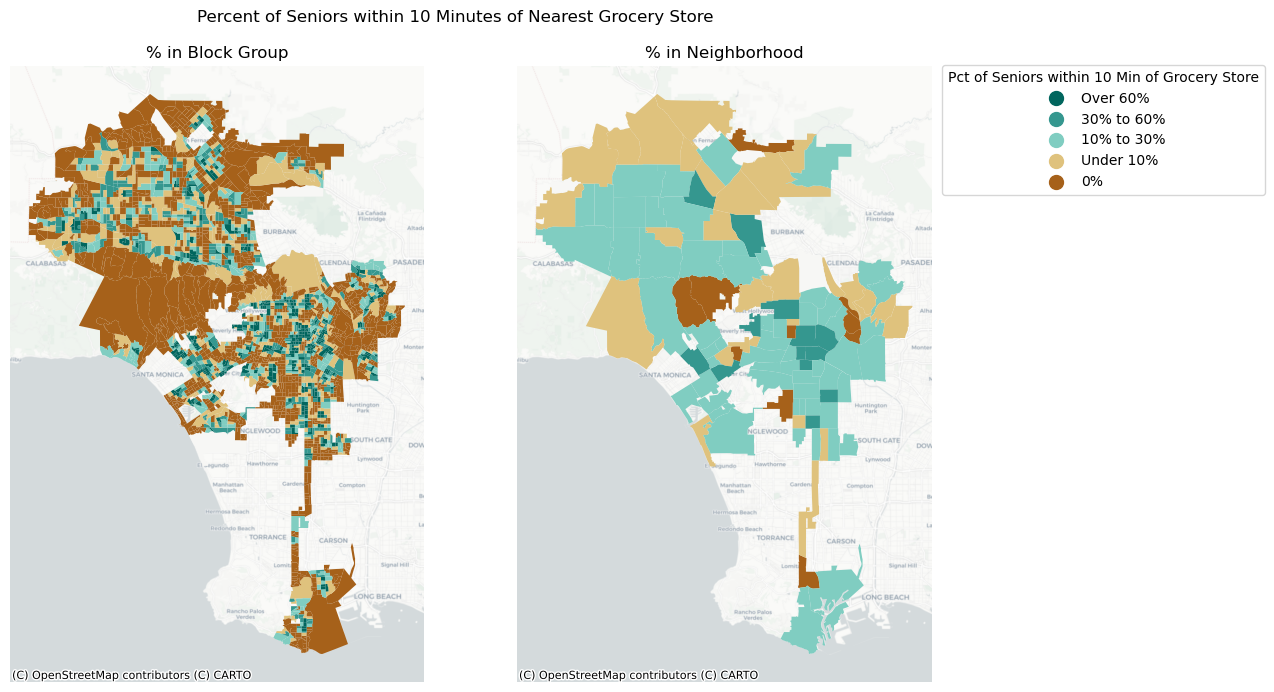

In [37]:
# Map all three subplots.
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

senior_grocery.plot(ax=ax[0],color=senior_grocery['colors'])
ax[0].axis("off")
ax[0].set_title("% in Block Group")
ctx.add_basemap(ax=ax[0], source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

# spatial lag map on the right
grocery_by_neighborhood.plot(ax=ax[1],color=grocery_by_neighborhood['colors'])
ax[1].axis("off")
ax[1].set_title("% in Neighborhood")
ctx.add_basemap(ax=ax[1], source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

# build custom legend
legend_elements = [(Line2D([0], [0], marker='o', color='#01665e', linestyle='',label='Over 60%', markersize=10)),
                  (Line2D([0], [0], marker='o', color='#35978f', linestyle='',label='30% to 60%', markersize=10)),
                  (Line2D([0], [0], marker='o', color='#80cdc1', linestyle='',label='10% to 30%', markersize=10)),
                  (Line2D([0], [0], marker='o', color='#dfc27d', linestyle='',label='Under 10%', markersize=10)),
                  (Line2D([0], [0], marker='o', color='#a6611a', linestyle='',label='0%', markersize=10))]

fig.legend(handles=legend_elements,loc='center left', bbox_to_anchor=(.9,.8), title="Pct of Seniors within 10 Min of Grocery Store")
fig.suptitle('Percent of Seniors within 10 Minutes of Nearest Grocery Store',x=0.5,y=.95)

plt.show()

### Part 4: What is the distribution of public transit like in LA? 
In this section, we will look at density of transit stops in the city of Los Angeles, and how that relates to where senior residents are living. We aim to identify whether/where there areas where there are high numbers of senior residents, and comparatively low density of transit options.

First we import data on neighborhood boundaries, transit stop locations, transity stop density, and senior population. The transit stop density and location files are compilations of data developed for the midterm, and saved as files for future use.

In [38]:
# Reset senior basemap.
seniors = gpd.read_file('data/Seniors_Basemap.geojson')

In [39]:
#read in transit stop data and create dataframes

#Spatial data for public transit stops in City of LA
transit_stops = gpd.read_file('data/transit_stops.geojson')
#Information on number of public transit stops per 
transit_density = pd.read_csv('data/transit_stopcount.csv')
lowtransitdensebg = gpd.read_file('data/lowdensityblockgroups.geojson')
hightransitdensebg= gpd.read_file('data/highdensityblockgroups.geojson')

#read in LA Times Neighborhood Boundaries 
neighborhoods = gpd.read_file('data/LA_Times_Neighborhood_Boundaries.geojson')

### Map of Transit Stop Locations and Senior Density

First, we look at where public transit stops are located in LA, and how that compares to where seniors are most densely located.

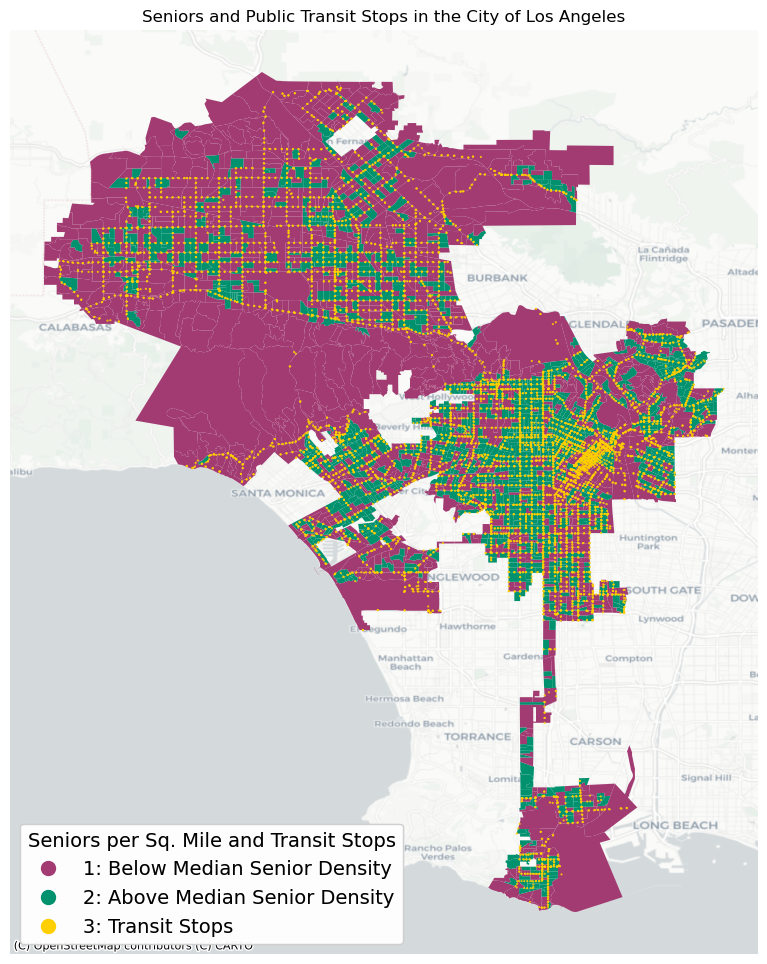

In [41]:
# I am going to have to create a manual legend since I have multiple layers, so I will first create a color dictionary.
color_dict = {'1: Below Median Senior Density': '#A23B72',
 '2: Above Median Senior Density': '#00916E',
 '3: Transit Stops': '#FFCF00'}

# Now I create a "colors" column in each separate dataframe that denotes the color I want things to show up as.

seniors.loc[seniors["Pop Density"] < 135.000000, "colors"]= '#A23B72' 
seniors.loc[seniors["Pop Density"] >= 135.000000, "colors"]= '#00916E' 
transit_stops["colors"] = '#FFCF00'

#Plot Bus Stops and Metro Stops on top of Senior Population Density
fig,ax = plt.subplots(figsize=(12,12))
ax1=seniors.plot(ax=ax,zorder=1,color=seniors['colors'])

#plot LA metro bus stops
ax2=transit_stops.plot(ax=ax, zorder=2, marker='.',markersize=1,legend=True,color=transit_stops['colors'])
                                                                                                
# Add manual legend.
from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
leg_points = ax.legend(custom_points, color_dict.keys(), title="Seniors per Sq. Mile and Transit Stops",fontsize = 14)
leg_points.get_title().set_fontsize('14') 
ax.add_artist(leg_points)


#Format plot.
ax.axis('off')
ax.set_title('Seniors and Public Transit Stops in the City of Los Angeles')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=4326)

### Map of Density of Transit Stops

Next, we look at density of transit stops to get a better spatial metric. The following map shows block groups in the top and bottom quartiles (highest and lowest) of transit stops/block group. This can help provide a visual of areas that might be good to focus in on for futher analysis.

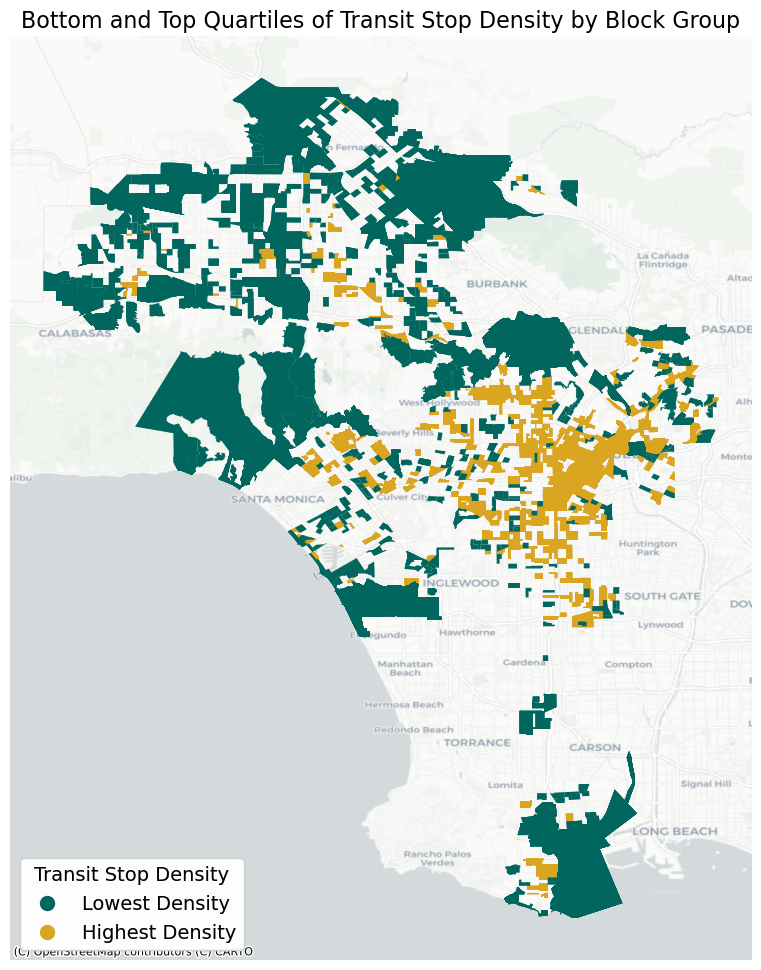

In [45]:
# Add manual legend
color_dict = {'Lowest Density': '#01665e',
 'Highest Density': '#DAA520'}

# Now I create a "colors" column in each separate dataframe that denotes the color I want things to show up as.
lowtransitdensebg["colors"] = '#01665e'
hightransitdensebg["colors"] = '#DAA520'

# Now I create my actual map with the three geodataframes added in the appropriate order (zorder).
fig,ax = plt.subplots(figsize=(12,12))
lowtransitdensebg.plot(ax=ax, zorder=2, color=lowtransitdensebg['colors'])
hightransitdensebg.plot(ax=ax, zorder=1, color=hightransitdensebg['colors'])

# Add manual legend.
from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
leg_points = ax.legend(custom_points, color_dict.keys(),loc='lower left', title="Transit Stop Density", fontsize = 14)
leg_points.get_title().set_fontsize('14') 
ax.add_artist(leg_points)

#Format plot.
ax.axis('off')
ax.set_title('Bottom and Top Quartiles of Transit Stop Density by Block Group',fontsize = 16)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=4326)

### Scaling Up to Neighborhoods

Since we hope to pick several neighborhoods to focus in on for more analysis, we need to connect this information to neighborhood boundaries.

In [ ]:
#What are the unique neighborhood names? 
neighborhoods.name.unique()

We will join the transit_stops geodataframe to the LA neighborhood boundaries.

In [ ]:
#spatial join of transit stop locations and neighborhood boundaries
transit_stops_nbrhood = gpd.sjoin(transit_stops, neighborhoods)
#display
transit_stops_nbrhood.sample(1)

In [ ]:
#Use valuecounts to get the number of unique stops per neighborhood
transit_nbrhood_count= transit_stops_nbrhood.value_counts(['name']).reset_index(name='stop_count')
#display statistics 
transit_nbrhood_count.describe()

In [ ]:
#Create dataframe of lowest quartile of # of transit stops/neighborhood.
low25_nbhd = transit_nbrhood_count[transit_nbrhood_count["stop_count"] < 37.000000]
#rename columns for plotting
low25_nbhd = low25_nbhd.rename(columns={'stop_count': 'Number of Public Transit Stops', 'name': 'Neighborhood'})

In [ ]:
#Plot bar graph
ax = low25_nbhd.plot.bar(x='Neighborhood', y='Number of Public Transit Stops', rot=90)

A next step will include calculating area of the neighborhood boundary polygons and adding a density column to the neighborhood transit stop dataframe, so that we can identify neighborhoods with the lowest geographic density of public transit stops. 

### Neighborhood Prioritization

Potential Method 1: Index from 0 to 100.

In [ ]:
neighborhood_seniors['Senior_Index']=(neighborhood_seniors['Pct Seniors']-neighborhood_seniors['Pct Seniors'].min())*100/(
    neighborhood_seniors['Pct Seniors'].max()-neighborhood_seniors['Pct Seniors'].min())

vehicles_by_neighborhood['Vehicle_Index']=(vehicles_by_neighborhood['Pct Senior-Headed Households Without a Vehicle']-vehicles_by_neighborhood['Pct Senior-Headed Households Without a Vehicle'].min())*100/(
    vehicles_by_neighborhood['Pct Senior-Headed Households Without a Vehicle'].max()-vehicles_by_neighborhood['Pct Senior-Headed Households Without a Vehicle'].min())

transit_nbrhood_count['Stop_Index']=-(transit_nbrhood_count['stop_count']-transit_nbrhood_count['stop_count'].min())*100/(
    transit_nbrhood_count['stop_count'].max()-transit_nbrhood_count['stop_count'].min())+100
transit_nbrhood_count=transit_nbrhood_count.rename(columns={'name':'neighborhood'})

grocery_by_neighborhood['Grocery_Index']=grocery_by_neighborhood['pct_snr_none']*100

In [ ]:
neighborhood_priority=pd.merge(neighborhood_seniors[['neighborhood','geometry','Senior_Index']],vehicles_by_neighborhood[['neighborhood','Vehicle_Index']],on=['neighborhood'],how='left')
neighborhood_priority=pd.merge(neighborhood_priority,grocery_by_neighborhood[['neighborhood','Grocery_Index']],on=['neighborhood'],how='left')
neighborhood_priority=pd.merge(neighborhood_priority,transit_nbrhood_count[['neighborhood','Stop_Index']],on=['neighborhood'],how='left')
neighborhood_priority['Priority_Index']=(neighborhood_priority['Senior_Index']+neighborhood_priority['Vehicle_Index']+neighborhood_priority['Grocery_Index']+neighborhood_priority['Stop_Index'])/4
neighborhood_priority=neighborhood_priority.sort_values(by=['Priority_Index'],ascending=False)
neighborhood_priority.iloc[0:15]

In [ ]:
def priorityplt(num):
    fig,ax = plt.subplots(figsize=(8,8))
    neighborhood_priority.iloc[0:num].plot(ax=ax,color='darkgreen')
    micro.plot(ax=ax,color='grey')
    ax.axis('off')
    ax.set_title('Top '+str(num)+' Highest Scoring Neighborhoods')
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=4326)

In [ ]:
priorityplt(20)

Potential Method 3: z-scores at the block group level

In [ ]:
# Senior population
seniors_index=gpd.read_file('Percent_Senior_Basemap.geojson').to_crs('epsg:6423')
seniors_index=seniors_index[['BG20','Total Pop','Pct Seniors']]
seniors_index.sample(3)

# Senior vehicle access
vehicle_index=gpd.read_file('vehicle_access.geojson')
vehicle_index=vehicle_index[['BG20','Pct Senior-Headed Households Without a Vehicle']]

# Grocery store access.
grocery_index=senior_grocery[['BG20','pct_none','geometry']]
grocery_index['pct_none']=grocery_index['pct_none']*100

# Transit stop density
transit_index=pd.read_csv('data/transit_stopcount.csv')
transit_index=transit_index[['BG20','stopdensity']]
transit_index['BG20']=transit_index['BG20'].astype(str)

# Merge
bg_priority=pd.merge(grocery_index,seniors_index,how='left',on=['BG20'])
bg_priority=pd.merge(bg_priority,vehicle_index,how='left',on=['BG20'])
bg_priority=pd.merge(bg_priority,transit_index,how='left',on=['BG20'])
bg_priority['stopdensity']=bg_priority['stopdensity'].fillna(0)
bg_priority.sample(3)

# Calculate z-scores.
from scipy import stats
bg_priority['seniors_z']=stats.zscore(bg_priority['Pct Seniors'], nan_policy='omit')
bg_priority['vehicle_z']=stats.zscore(bg_priority['Pct Senior-Headed Households Without a Vehicle'], nan_policy='omit')
bg_priority['grocery_z']=stats.zscore(bg_priority['pct_none'], nan_policy='omit')
bg_priority['transit_z']=stats.zscore(bg_priority['stopdensity'], nan_policy='omit')
bg_priority.describe()

# Average z-scores for available data.
bg_priority['Priority_Index']=(bg_priority['seniors_z']+bg_priority['vehicle_z']+bg_priority['grocery_z']+bg_priority['transit_z'])/4
bg_priority.loc[bg_priority['Pct Senior-Headed Households Without a Vehicle'].isna(), 'Priority_Index'] = (bg_priority['seniors_z']+bg_priority['grocery_z']+bg_priority['transit_z'])/3

Maybe we want to look at spatial autocorrelation???

In [ ]:
# For spatial statistics
import libpysal as lps
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(bg_priority,k=8)
# Row-standardization
wq.transform = 'r'
# create a new column for the spatial lag
bg_priority['priority_lag'] = lps.weights.lag_spatial(wq, bg_priority['Priority_Index'])

In [ ]:
# Map index (regular vs. spatial lag)
fig, ax = plt.subplots(1,2,figsize=(12, 8))
bg_priority.plot(ax=ax[0],column='Priority_Index',scheme='quantiles',cmap='RdYlGn_r')
bg_priority.plot(ax=ax[1],column='priority_lag',scheme='quantiles',cmap='RdYlGn_r')
neighborhoods.plot(ax=ax[1],facecolor='none')

#Format plot.
ax[0].axis('off')
ax[1].axis('off')
ctx.add_basemap(ax=ax[0], source=ctx.providers.CartoDB.Positron, crs='epsg:6423')
ctx.add_basemap(ax=ax[1], source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

Is anything "statistically significant"?

In [ ]:
bg_priority=bg_priority[bg_priority['Priority_Index']<100]

In [ ]:
# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(bg_priority,k=8)
# Row-standardization
wq.transform = 'r'

y = bg_priority.Priority_Index
moran = Moran(y, wq)
moran.I

# calculate local moran values
lisa = esda.moran.Moran_Local(y, wq)

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
lisa_cluster(lisa, bg_priority, p=0.05, ax=ax)
plt.show()

In [ ]:
# First I followed this documentation (https://github.com/pysal/splot/blob/main/splot/_viz_utils.py)
# This code creates a function to return an array of cluster memberships at a given level of significance.
def moran_hot_cold_spots(moran_loc, p=0.05):
    sig = 1 * (moran_loc.p_sim < p)
    HH = 1 * (sig * moran_loc.q == 1)
    LL = 3 * (sig * moran_loc.q == 3)
    LH = 2 * (sig * moran_loc.q == 2)
    HL = 4 * (sig * moran_loc.q == 4)
    cluster = HH + LL + LH + HL
    return cluster

# Call function (results in an array).
cluster_results=moran_hot_cold_spots(lisa, p=0.05)

# Convert array to a dataframe and then merge it with the bg_priority dataframe.
lisa_df = pd.DataFrame(cluster_results,columns = ['lisa'])
bg_priority=bg_priority.reset_index().drop(columns=['index'])
bg_lisa=pd.merge(bg_priority,lisa_df,left_index=True, right_index=True)

# Plot to see if this worked.
bg_lisa.plot(column='lisa',legend=True)

Finally, we can use my neighborhood exploere to zoom in on these potential priority places!!!

In [ ]:
# Reimport projected versions of data used below.
neighborhoods=gpd.read_file(
    'https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson').to_crs('epsg:6423').rename(columns={'name' : 'neighborhood'})
transit_stops=transit_stops.to_crs('epsg:6423')

def neighborhood_map(neighborhood_list):
    # Loop through all neighborhoods to get their combined geographic extent.
    neighborhood_boundary=gpd.GeoDataFrame(columns=['OBJECTID', 'neighborhood', 'geometry'],crs="EPSG:6423")
    for i in neighborhood_list:
        boundary=neighborhoods[(neighborhoods["neighborhood"]==i)]
        neighborhood_boundary = pd.concat([neighborhood_boundary,boundary])
    # Overlay this new geographic extent with the walksheds to get just walksheds within the neighborhoods.    
    neighborhood_walkshed=gpd.overlay(walksheds,neighborhood_boundary,how='intersection', keep_geom_type=None, make_valid=True)
    # Clip point data to get just points within the neighborhoods.
    neighborhood_stores=gpd.clip(grocery_chains,neighborhood_boundary)
    neighborhood_stops=gpd.clip(transit_stops,neighborhood_boundary)
    
    # Set colors.
    neighborhood_boundary["colors"] = '#a6611a'

        
    # Make plot for all of these layers clipped to the desired neighborhoods.
    fig, ax= plt.subplots(figsize=(7,7))
    neighborhood_walkshed.plot(ax=ax,zorder=2,color=neighborhood_walkshed['colors'],alpha=.8)
    neighborhood_boundary.plot(ax=ax,zorder=1,color=neighborhood_boundary['colors'],alpha=0.4)
    neighborhood_stores.plot(ax=ax,zorder=4,marker='X',color='white', edgecolor='black',markersize=50)
    neighborhood_stops.plot(ax=ax,zorder=3,marker='o',color='#FFCF00', edgecolor='black',markersize=10)
    
    # Create custom legend
    from matplotlib.lines import Line2D
    legend_elements = [(Line2D([0], [0], marker='X', color='white', markeredgecolor='black', label='Grocery store location', markersize=10)),
                      (Line2D([0], [0], marker='o', color='#01665e', linestyle='',label='Grocery store within 5 min', markersize=10)),
                      (Line2D([0], [0], marker='o', color='#35978f', linestyle='',label='Grocery store within 10 min', markersize=10)),
                      (Line2D([0], [0], marker='o', color='#80cdc1', linestyle='',label='Grocery store within 15 min', markersize=10)),
                      (Line2D([0], [0], marker='o', color='#a6611a', linestyle='',label='No walkable grocery store', markersize=10))]
    ax.legend(handles=legend_elements,loc='upper left', bbox_to_anchor=(1,.9), title="Distance to Nearest Grocery Store")
    
    # Customize axis, title, and basemap.
    ax.axis('off')
    title='Distance to nearest grocery store: '
    for i in neighborhood_list:
        title=title+i+', '
    title=title[:-2]    
    ax.set_title(title)
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

In [ ]:
neighborhood_map(['Granada Hills'])
neighborhood_map(['Shadow Hills', 'Hansen Dam', 'Sunland', 'Tujunga', 'Lake View Terrace'])
neighborhood_map(['Pacific Palisades', 'Brentwood','Bel-Air','Beverly Crest'])
neighborhood_map(['Chinatown', 'Downtown','Boyle Heights','Lincoln Heights'])

### Division of Labor:
<b>Carolyn:</b> Carolyn focused on analyses related to fixed route transit.<br>
<b>Lucy:</b> Lucy focused on analyses related to the senior population and Metro Micro zones.<br>
<b>Monisha:</b> Monisha focused on analyses related to household vehicle access and grocery store access.